# Detecting Broken Smartphone Screen

### Importing the packages

In [11]:
import pandas as pd       
import numpy as np
import seaborn as sns

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, glob, sys
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
import torch.nn.functional as F
from PIL import Image


### Mounting google drive

In [2]:
# Mounting google drive, so that we could import the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#Input data files are available in the google drive directory.
#data_dir = '/content/drive/MyDrive/training/'
data_dir = 'data/training/'


for class_dir in glob.glob(data_dir + os.sep + '*'):
    print(class_dir)

data/training/not_damage
data/training/less_damage
data/training/severly_damage


### Exploratory Data Analysis 

In [13]:
less_path = os.path.join(data_dir,"less_damage")
not_path = os.path.join(data_dir,"not_damage")
serv_path = os.path.join(data_dir,"severly_damage")

In [14]:
less_damage = glob.glob(less_path+"/*.jpg")
not_damage = glob.glob(not_path+"/*.jpg")
severly_damage = glob.glob(serv_path +"/*.jpg")

In [15]:
train_list = [x for x in less_damage]
train_list.extend([x for x in not_damage])
train_list.extend([x for x in severly_damage])

In [16]:
df_train = pd.DataFrame(np.concatenate([['less_damage']*len(less_damage) , ['not_damage']*len(not_damage), ['severly_damage']*len(severly_damage)]), columns = ['class'])

In [17]:
df_train['image'] = [x for x in train_list]

In [18]:
df_train.head(10)

,class,image
0,less_damage,data/training/less_damage/less_damage81.jpg
1,less_damage,data/training/less_damage/less_damage426.jpg
2,less_damage,data/training/less_damage/less_damage340.jpg
3,less_damage,data/training/less_damage/less_damage354.jpg
4,less_damage,data/training/less_damage/less_damage432.jpg
5,less_damage,data/training/less_damage/less_damage95.jpg
6,less_damage,data/training/less_damage/less_damage368.jpg
7,less_damage,data/training/less_damage/less_damage42.jpg
8,less_damage,data/training/less_damage/less_damage383.jpg
9,less_damage,data/training/less_damage/less_damage397.jpg


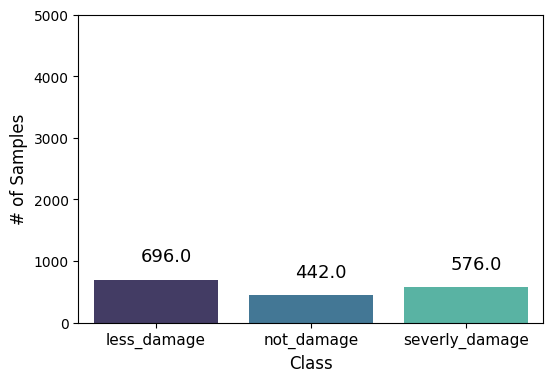

In [19]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1, 2], ['less_damage', 'not_damage', 'severly_damage'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

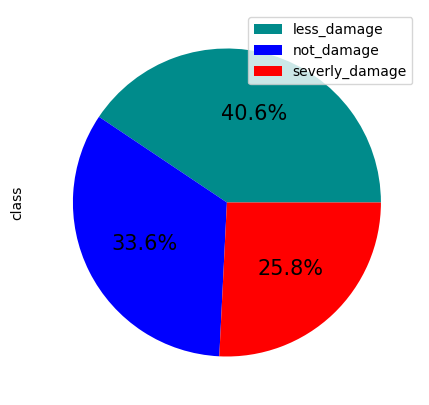

In [29]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['','',''], autopct='%1.1f%%', colors = ['darkcyan','blue', 'red'], explode = [0,0.0,0], textprops = {"fontsize":15})

plt.legend(labels=['less_damage', 'not_damage', 'severly_damage'])
plt.show()

In [13]:
IMG_SIZE = 224

- Less_Damage


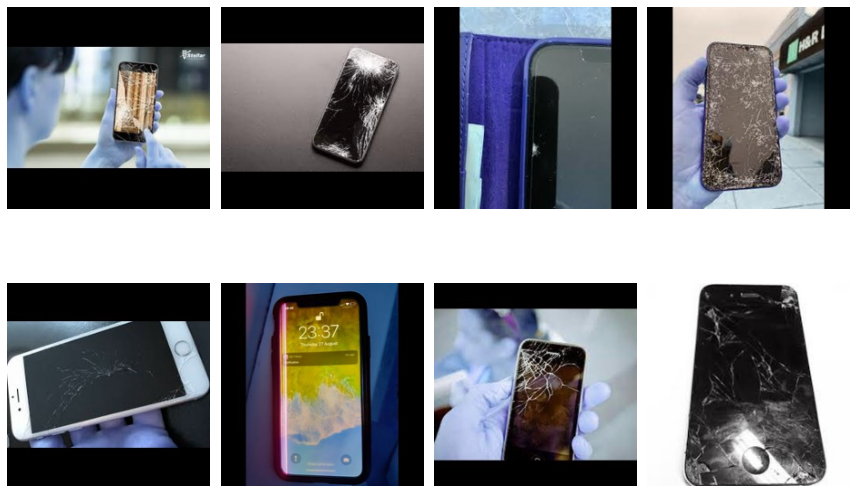

In [14]:
print('- Less_Damage')

plt.figure(figsize=(12,12))

for i in range(4,12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(less_damage[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


- Not Damage


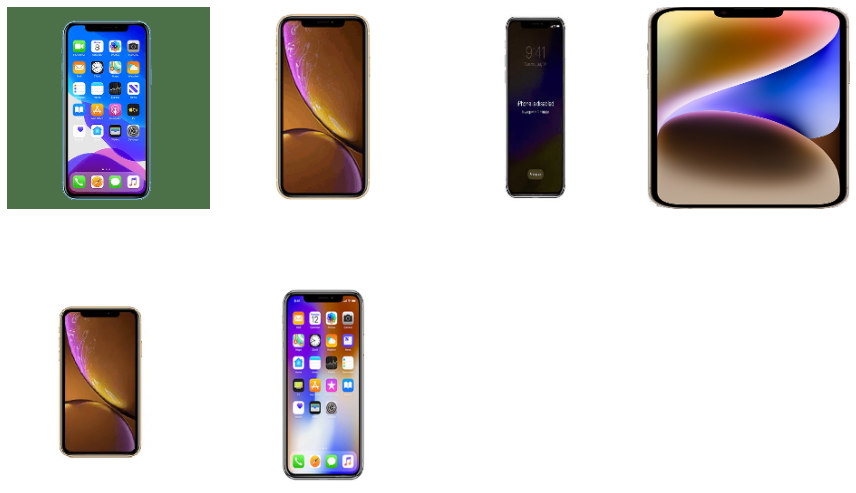

In [15]:
print('- Not Damage')

plt.figure(figsize=(12,12))

for i in range(4, 10):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(not_damage[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


- Severly Damage


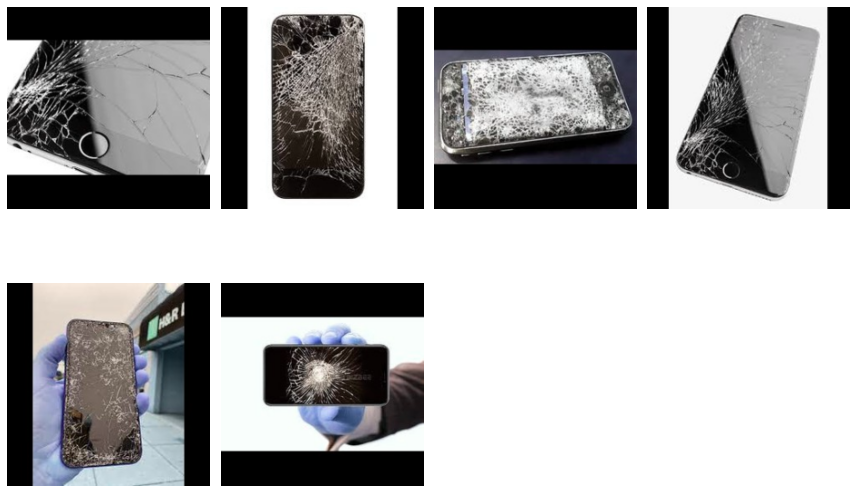

In [16]:
print('- Severly Damage')

plt.figure(figsize=(12,12))

for i in range(4, 10):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(severly_damage[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


### Feature Engineering & Data Preparation 

In [30]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

print('data_transforms: ', data_transforms)

dataset = datasets.ImageFolder(data_dir, transform = data_transforms)
print('dataset: ', dataset)

# We need to split the dataset between train and val datasets
train_percentage = 0.8
train_size = int(len(dataset)*train_percentage)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print('\nnumber of examples in train_dataset: ', len(train_dataset))
print('number of examples in val_dataset  : ', len(val_dataset))

data_transforms:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
dataset:  Dataset ImageFolder
    Number of datapoints: 1714
    Root location: data/training/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

number of examples in train_dataset:  1371
number of examples in val_dataset  :  343


In [18]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size = batch_size, shuffle = False)

print('number of batches in train_loader with a batch_size of {}: {}'.format(batch_size,  len(train_loader)))
print('number of batches in val_loader with a batch_size of {}: {}'.format(batch_size,  len(val_loader)))

number of batches in train_loader with a batch_size of 64: 22
number of batches in val_loader with a batch_size of 64: 6


In [19]:
print('dataset.classes: ', dataset.classes)


dataset.classes:  ['less_damage', 'not_damage', 'severly_damage']


In [20]:
# Defining the model
model = models.resnet34(pretrained = True)

# The original architecture of resnet34 has 1000 neurons(corresponding to 1000 classes on which it was originally trained on) in the final layer.
print('model.fc before: ', model.fc)
model_fc_in_features = model.fc.in_features
model.fc = nn.Linear(model_fc_in_features, len(dataset.classes))
print('model.fc after : ', model.fc)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

model.fc before:  Linear(in_features=512, out_features=1000, bias=True)
model.fc after :  Linear(in_features=512, out_features=3, bias=True)


In [21]:
for name, module in model.named_children():
    print('name: ', name)

name:  conv1
name:  bn1
name:  relu
name:  maxpool
name:  layer1
name:  layer2
name:  layer3
name:  layer4
name:  avgpool
name:  fc


### Model Training 

In [22]:
def trainer(dataloader_dict, model, loss_fn, optimizer, epochs = 1, log_interval = 1):
  print('Training started...')
  train_losses = []
  val_losses = []
  batch_train_losses = []
  batch_val_losses = []
  for epoch in range(epochs):
      print('epoch >>> {}/{}'.format(epoch + 1, epochs))

      for phase in ['train', 'val']:
          if phase == 'train':
              print('___TRAINING___')
              model.train()
          else:
              print('___VALIDATION___')
              model.eval()

          epoch_loss = 0    
          for batch_idx, (inputs, labels) in enumerate(loader[phase]):
              # Zero the parameter gradients
              optimizer.zero_grad()

              # forward
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  batch_loss = loss_fn(outputs, labels)
                  epoch_loss += batch_loss.item()*inputs.shape[0]
                  
                  # Saving the batch losses
                  if phase == 'train':
                      batch_train_losses.append(batch_loss.item())
                  else:
                      batch_val_losses.append(batch_loss.item())
                  
                  if phase == 'train':
                      # Backpropagation
                      batch_loss.backward()
                      optimizer.step()

              if (batch_idx + 1)%log_interval == 0:
                  print('batch_loss at batch_idx {}/{}: {}'.format(str(batch_idx).zfill(len(str(len(train_loader)))), len(train_loader), batch_loss))

          mean_epoch_loss = epoch_loss/len(loader[phase].dataset)
          print('>>> {} loss at epoch {}/{}: {}'.format(phase, epoch + 1, epochs, mean_epoch_loss))
          
          # Storing the losses
          if phase == 'train':
              train_losses.append(mean_epoch_loss)
          else:
              val_losses.append(mean_epoch_loss)
      
      print('====='*5)
      
  return train_losses, val_losses, batch_train_losses, batch_val_losses


In [23]:
# Now we define the Loss Function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
lr = 0.00001
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

In [ ]:
loader = {'train': train_loader, 'val': val_loader}

epochs = 10
log_interval = 2

# Let's train the model for 10 epochs !
train_losses, val_losses, batch_train_losses, batch_val_losses = trainer(loader, model, loss_fn, optimizer, epochs = epochs, log_interval = log_interval)


Text(0.5, 1.0, 'batch_val_losses')

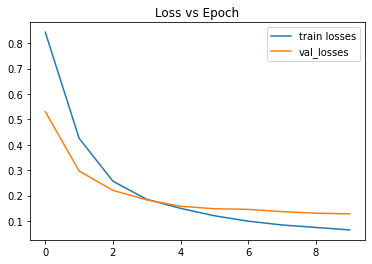

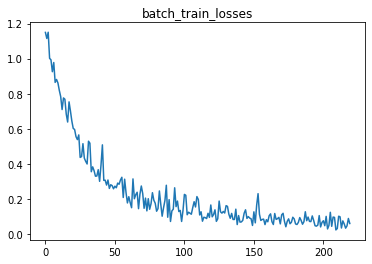

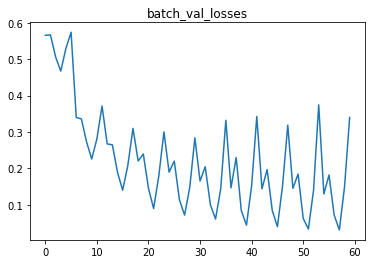

In [ ]:
# Ploting the epoch losses
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train losses', 'val_losses'])
plt.title('Loss vs Epoch')

plt.figure()
plt.plot(batch_train_losses)
plt.title('batch_train_losses')

plt.figure()
plt.plot(batch_val_losses)
plt.title('batch_val_losses')


In [ ]:
# Saving the model(architecture and weights)
torch.save(model, 'model.pth')

### Model Testing 

In [2]:
model = torch.load('model.pth')


It is predicted as >>> severly_damage <<<  with confidence of 95.68%


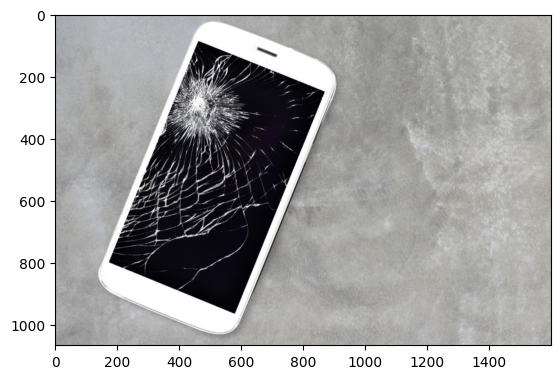

In [31]:
# Making a 'predict' function which would take the 'model' and the path of the 'test image' as inputs, and predict the class that the test image belongs to.
def predict(model, test_img_path):
  img = cv2.imread(test_img_path)
  
  # Visualizing the test image
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  
  img = transforms.Compose([transforms.ToPILImage()])(img)    
  img = data_transforms(img)
  img = img.view(1, img.shape[0], img.shape[2], img.shape[2]) # Expanding dimension
  model.eval()
  with torch.no_grad():
      logits = model(img)
      
  probs = F.softmax(logits, dim = 1)
  max_prob, ind = torch.max(probs, 1)
  
  print('It is predicted as >>> {} <<<  with confidence of {}%'.format(dataset.classes[ind], round(max_prob.item()*100, 2)))
  
#test_data_dir = '/content/drive/MyDrive/train_dir/test/android_samsung/'
test_data_dir = '/content/drive/MyDrive/test/'
test_data_dir = 'test/'

test_img_list = []
for class_dir in glob.glob(test_data_dir + os.sep + '*'):
    test_img_list.append(class_dir)
    
# Loading the trained model(architecture as well as the weights) for making inferences
model = torch.load('model.pth')

# Select the test image index(choose a number from 0 to 6)
test_img_index = 0
predict(model, test_img_list[test_img_index])


### Conclusion 

To sum up, this the end of the notebook, and if you run well, and add your datasets path properly, it would work smoothly. In addition to that, if you want to play with different models architecture you can do that as well, just to any pre-trained model that you wish to use, and change its name that's it. like currently, I used resnet18, u can change to other resnet like resnet34, resnet50 etc.... 